# Import libraries

In [1]:
# Set a jupyter notebook coding container to fit the borders of a web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Data structure
import pandas as pd
import numpy as np

# Statistics
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols, logit
from scipy.stats import chi2_contingency

# Ploting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Do not need to call plt.show() when ploting a graph
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # add plot figure back line

import seaborn as sns
sns.set()

In [3]:
# GridSearch
from sklearn.model_selection import GridSearchCV

# Outliers remover
from sklearn.ensemble import IsolationForest

# Data Preparations
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Main Model
import xgboost as xgb

# Models for justification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree

# Model comparison
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
#Set max display columns to max
pd.set_option('display.max_columns', None)

# Load data

In [5]:
# The list of the names that represent the missing values
missing_values = ["n/a", "na", "--","Unknown"]
raw_data = pd.read_csv("data/BankChurners.csv", na_values = missing_values)

In [6]:
# Drop the results of Navie_bayes Classifier
raw_data.drop(list(raw_data.iloc[:,-2:].columns),inplace=True,axis=1)

In [7]:
raw_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Cleaning functions

In [8]:
def drop_unbalanced_ratio(df):
    """ 
    Drop column that has an unbalanced unique value ratio (one unique value or excessive unique values).
    
    Notes:
    - One unique value or too many unique values columns doesn't give a decent analysis 
    because it doesn't give meaningful information.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The dataframe that dropped column that has one unique value or excessive unique values.
    
    """
    
    data = df.copy()
    
    print("\nDropped unbalanced ratio columns...")
    
    # Drop the columns that contain one unique value or 
    # Drop the column that has unique variables equal to the number of values. (Too many unqiue values inside)
    for col_name in data.columns:
        if data[col_name].count() == len(data[col_name].unique()) or len(data[col_name].unique()) == 1:
            print (col_name)
            data.drop(col_name, axis=1,inplace = True)

    return data

def z_outlier_filter(df):
    """ 
    Filter outliner by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    filtered_df: The removed outliner dataframe by using z score.
    
    """
    data = df.copy()
    
    # Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    # Set NaN to 0
    abs_z_scores[np.isnan(abs_z_scores)]= 0

    # The columns that have z-score > 3 are dropped
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter outlier by Isolation Forest.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values and not contain any missing values.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define IsolationForest
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select normal datapoints
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

## Feature selection function

In [9]:
def Chi_square_test(df, target):
    """ 
    Perform a Chi-square test.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    target: string. Target name.
    
    Returns:
    chi_square_dict: The pandas dataframe that hold p-values for input (categorical) columns
    
    """
    p_values = []
    # Select only categorical columns
    cat_feats = df.select_dtypes(exclude=['number']).drop(target,axis=1).copy()
    for col_name in cat_feats.columns:
        # pd.crosstab: get observed values 
        # Calculate p-values
        stat, p, dof, expected = chi2_contingency(pd.crosstab(df[target], raw_data[col_name]))
        # Store p-value for each column
        p_values.append(p)
    # Create DataFrame for holding p-values
    return pd.DataFrame(data={'column name': cat_feats.columns,'p-value':p_values})

## Data visualization functions

In [10]:
def countplot(df, col_name, size_x=4, size_y=5):
    """ 
    Plot count plot.
    
    Args:
    df: dataframe. The pandas dataframe.
    col_name: string. The column name.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    plt.figure(figsize=(size_x, size_y))
    ax = sns.countplot(x = col_name, data = df, palette="muted", order = df[col_name].value_counts().index)
    plt.ylabel('The number of customers')

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(str(round(height/len(df[col_name])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

def plot_pearson_corrs(df, size_x = 10, size_y = 7):
    """ 
    Plot Pearson's correlations.
    
    Args:
    df: dataframe. The feature pandas dataframe.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    # Set the size of axi
    plt.figure(figsize=(size_x,size_y))
    # Get Pearson correlation coefficient 
    cor = df.corr()
    # Plot heatmap
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show
    
def plot_swarmbox(df, feature, target, size_x=8, size_y=6, s=4.5):
    """ 
    Plot the data by using boxplot and swarmplot.
    
    Args:
    df: dataframe. The pandas dataframe.
    feature: dataframe serie. The categorical or discrete feature pandas serie.
    target: dataframe serie. The numeric target pandas serie.
    size_x: float. x axis size.
    size_y: float. y axis size.
    s: float. a marker size.
    
    """
    plt.figure(figsize=(size_x, size_y))
    ax = sns.swarmplot(x=feature, y=target, data=df, s=s)
    ax = sns.boxplot(x=feature, y=target, data=df, color='white', linewidth=s-1.5)
    plt.show()

In [11]:
def get_ratios(series):
    """ 
    Get ratio for each category in series.
    
    Args:
    series: series. The pandas series that must contain only categorical values.
    
    Returns:
    DataFrame_Ratios: The pandas dataframe that contains category ratio.
    
    """    
    percent_counts = [(series.value_counts()[val]/series.shape[0])*100 for val in list(series.value_counts().index)]
    return pd.DataFrame({'Category': series.value_counts().index, 'Ratio': percent_counts})

def stacked_plot(df, target, col_name, size_x =12, size_y = 3):
    """ 
    Plot stacked plot by accumulating bar plots.
    
    Args:
    df: dataframe. The pandas dataframe.
    col_name: string. The categorical or discrete feature name.
    target: string. The categorical target name.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    # Data preparation for stacked plot
    # Extract unique values into dictionaries 
    dict_cats = {}
    for idx in df[target].unique():
        dict_cats[idx] = df[df[target] == idx][col_name]

    # Find ratio for each category in extracted dictionaries
    cat_ratios = {}
    for cat in dict_cats:
        cat_ratios[cat] = get_ratios(dict_cats[cat]).sort_values('Category')
        
    # Concatenate ratios from all target categories
    ratio_dicts = {}
    for idx, cat in enumerate(df[col_name].value_counts().index):
        tmp_ratios = []
        for key in cat_ratios:
            tmp_ratios.append(cat_ratios[key]['Ratio'][idx])
        ratio_dicts[cat] = tmp_ratios
        
    # Create numpy array to combine the values for each category
    list_ratios = []
    for key in ratio_dicts:
        list_ratios.append(ratio_dicts[key])
    arr_ratio = np.array(list_ratios)
    
    # Plot stacked_plot
    plt.figure(figsize=(size_x,size_y))
    plt.title(target + ' and ' + col_name)
    
    # Define target category names
    r = removed_outlier[target].unique()

    for idx, cat in enumerate(ratio_dicts):
        if idx == 0:
            # Plot horizon bar
            plt.barh(r, ratio_dicts[cat], edgecolor='white')
        else:
            # Declare left with size correspond to ratio and repalce all values with 0.0 for calcalation
            bottom = np.where(arr_ratio[0] > 0, 0, arr_ratio[0])
            for i in range(idx):
                bottom += arr_ratio[i]
            plt.barh(r, ratio_dicts[cat], left=bottom, edgecolor='white')
    plt.legend(ratio_dicts,loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Data exploration

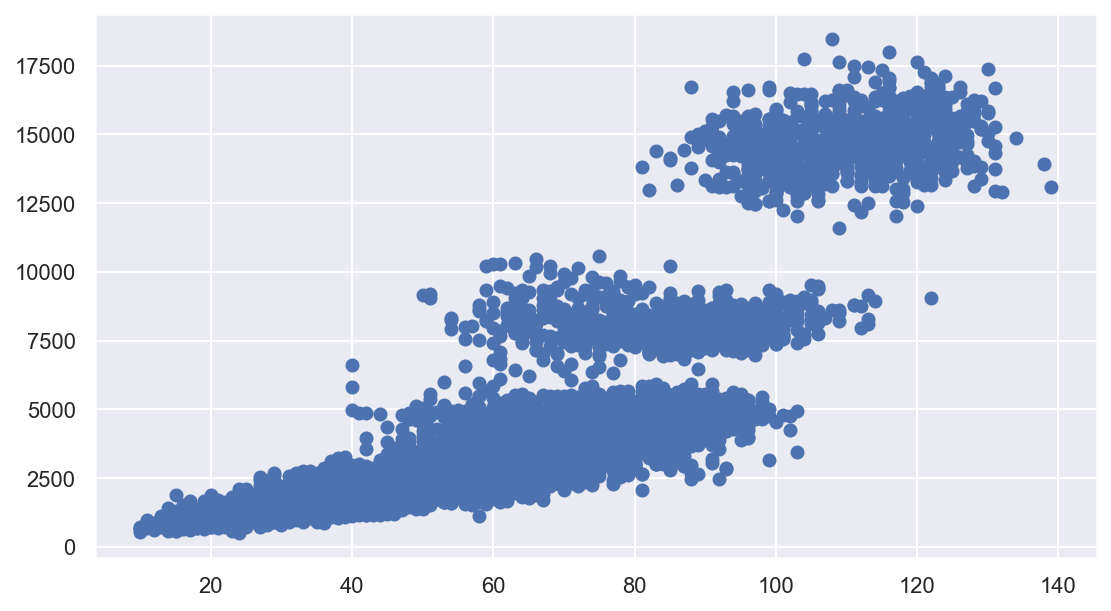

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(raw_data['Total_Trans_Ct'],raw_data['Total_Trans_Amt'])
plt.show()   

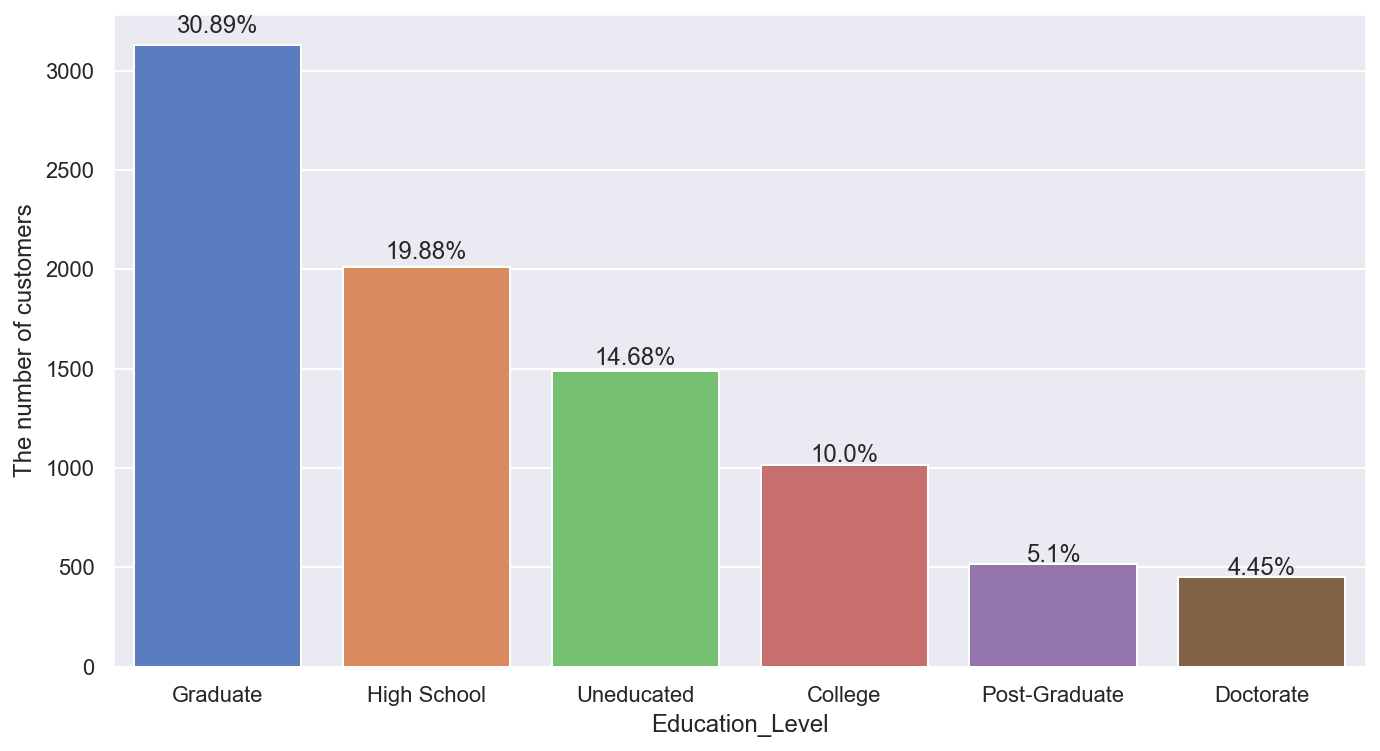

In [13]:
countplot(raw_data, 'Education_Level', 10, 6)

<AxesSubplot:xlabel='Credit_Limit', ylabel='Count'>

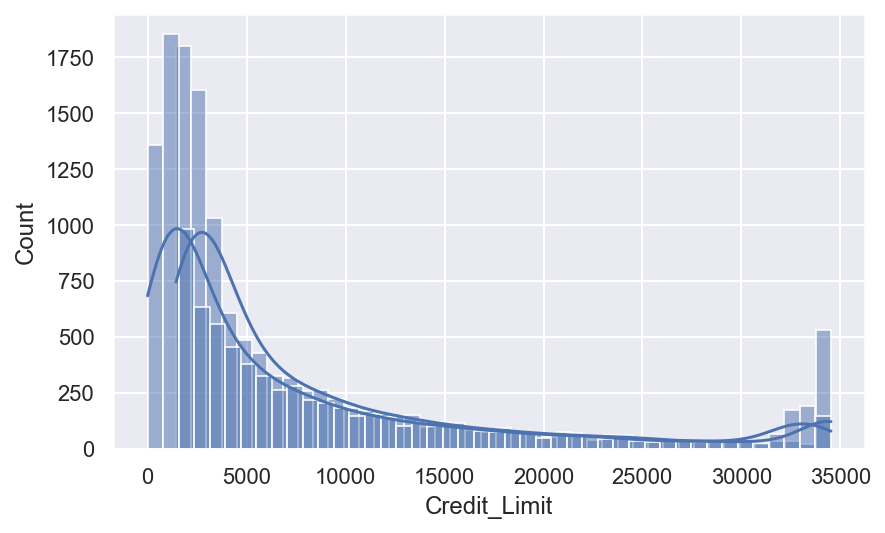

In [14]:
# Similar
sns.histplot(raw_data['Credit_Limit'], kde=True)
sns.histplot(raw_data['Avg_Open_To_Buy'], kde=True)

<AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Count'>

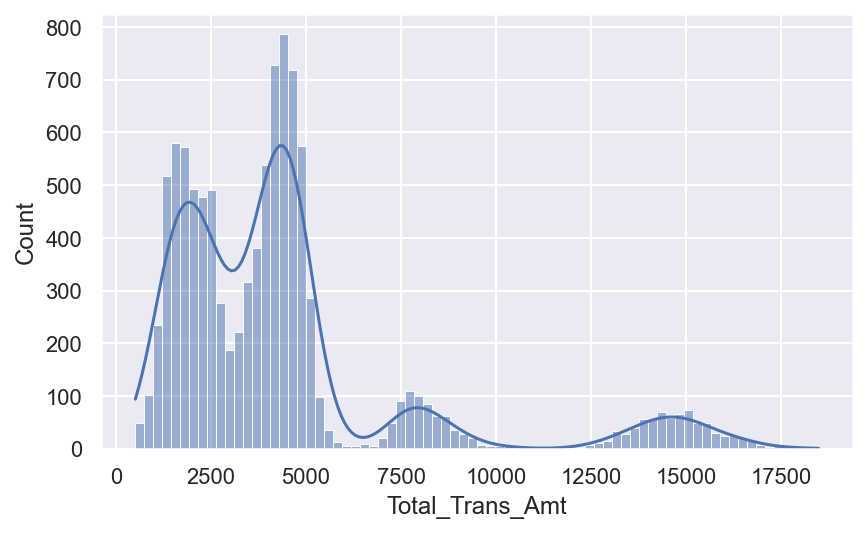

In [15]:
# Remove
sns.histplot(raw_data['Total_Trans_Amt'], kde=True)

<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Count'>

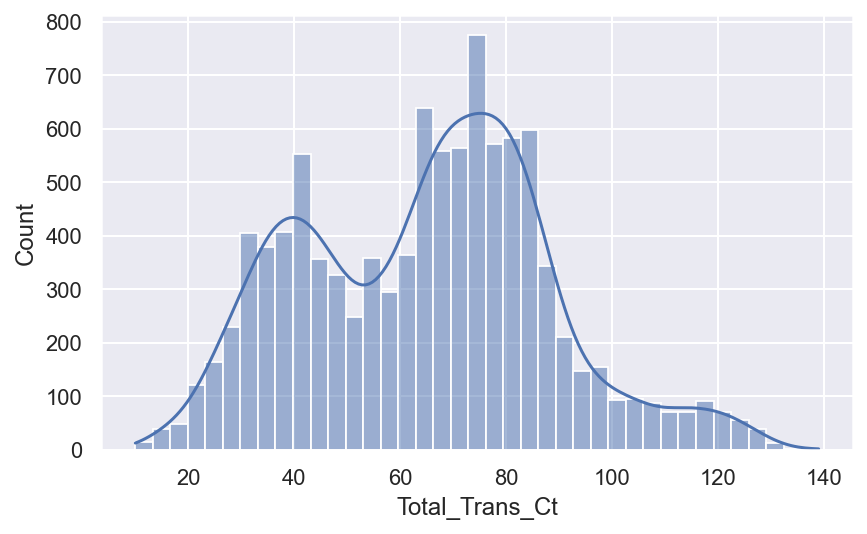

In [16]:
sns.histplot(raw_data['Total_Trans_Ct'], kde=True)

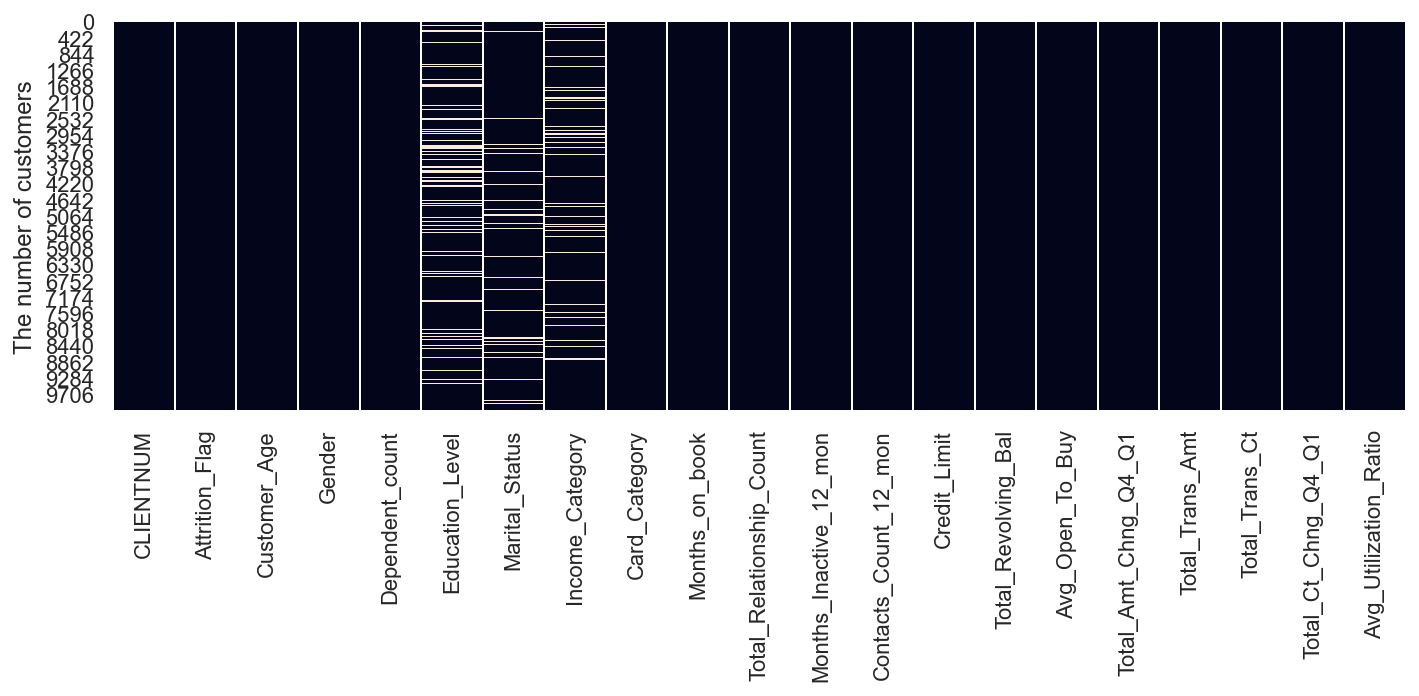

In [17]:
# Plot the missing values
plt.figure(figsize=(10, 5))
ax = sns.heatmap(raw_data.isnull(), cbar=False)
plt.ylabel('The number of customers')
for i in range(raw_data.isnull().shape[1]+1):
    ax.axvline(i, color='white', lw=1)
plt.tight_layout()

# Cleaning data

In [18]:
# Check NaN
raw_data.columns[raw_data.isnull().mean()>0.75]

Index([], dtype='object')

In [19]:
# Drop NaN values
df = raw_data.dropna()

In [20]:
# Drop unbalanced ratio
drop_unbalanced_ratio(df)


Dropped unbalanced ratio columns...
CLIENTNUM


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Existing Customer,54,M,1,High School,Single,$60K - $80K,Blue,34,5,2,0,13940.0,2109,11831.0,0.660,15577,114,0.754,0.151
10121,Existing Customer,56,F,1,Graduate,Single,Less than $40K,Blue,50,4,1,4,3688.0,606,3082.0,0.570,14596,120,0.791,0.164
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


## Remove outliers

In [21]:
# Separate numeric and non-numeric features
numeric_feats = df.select_dtypes(include='number')
non_num_feats = df.select_dtypes(exclude='number')

### Isolation Forest

In [22]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(numeric_feats)

### Merge data after remove outlier

In [23]:
# Drop the columns that has an unbalanced unique value ratio after removed outliers
anomaly_solved = drop_unbalanced_ratio(anomaly_solved)
    
# Combine numeric features and catergorical features
non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
removed_outlier = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape


Dropped unbalanced ratio columns...
CLIENTNUM


(5242, 20)

In [24]:
# Finished cleaning dataset
removed_outlier.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,M,Graduate,Married,$40K - $60K,Blue,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
1,Existing Customer,M,Graduate,Single,$80K - $120K,Blue,48,2,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144
2,Existing Customer,F,Graduate,Married,Less than $40K,Blue,57,2,48,5,2,2,2436.0,680,1756.0,1.190,1570,29,0.611,0.279
3,Existing Customer,F,Graduate,Single,Less than $40K,Blue,41,3,28,6,1,2,7768.0,1669,6099.0,0.797,1051,22,0.833,0.215
4,Existing Customer,F,College,Married,Less than $40K,Blue,53,2,38,5,2,3,2650.0,1490,1160.0,1.750,1411,28,1.000,0.562


# Feature selction

## Pearson correlation

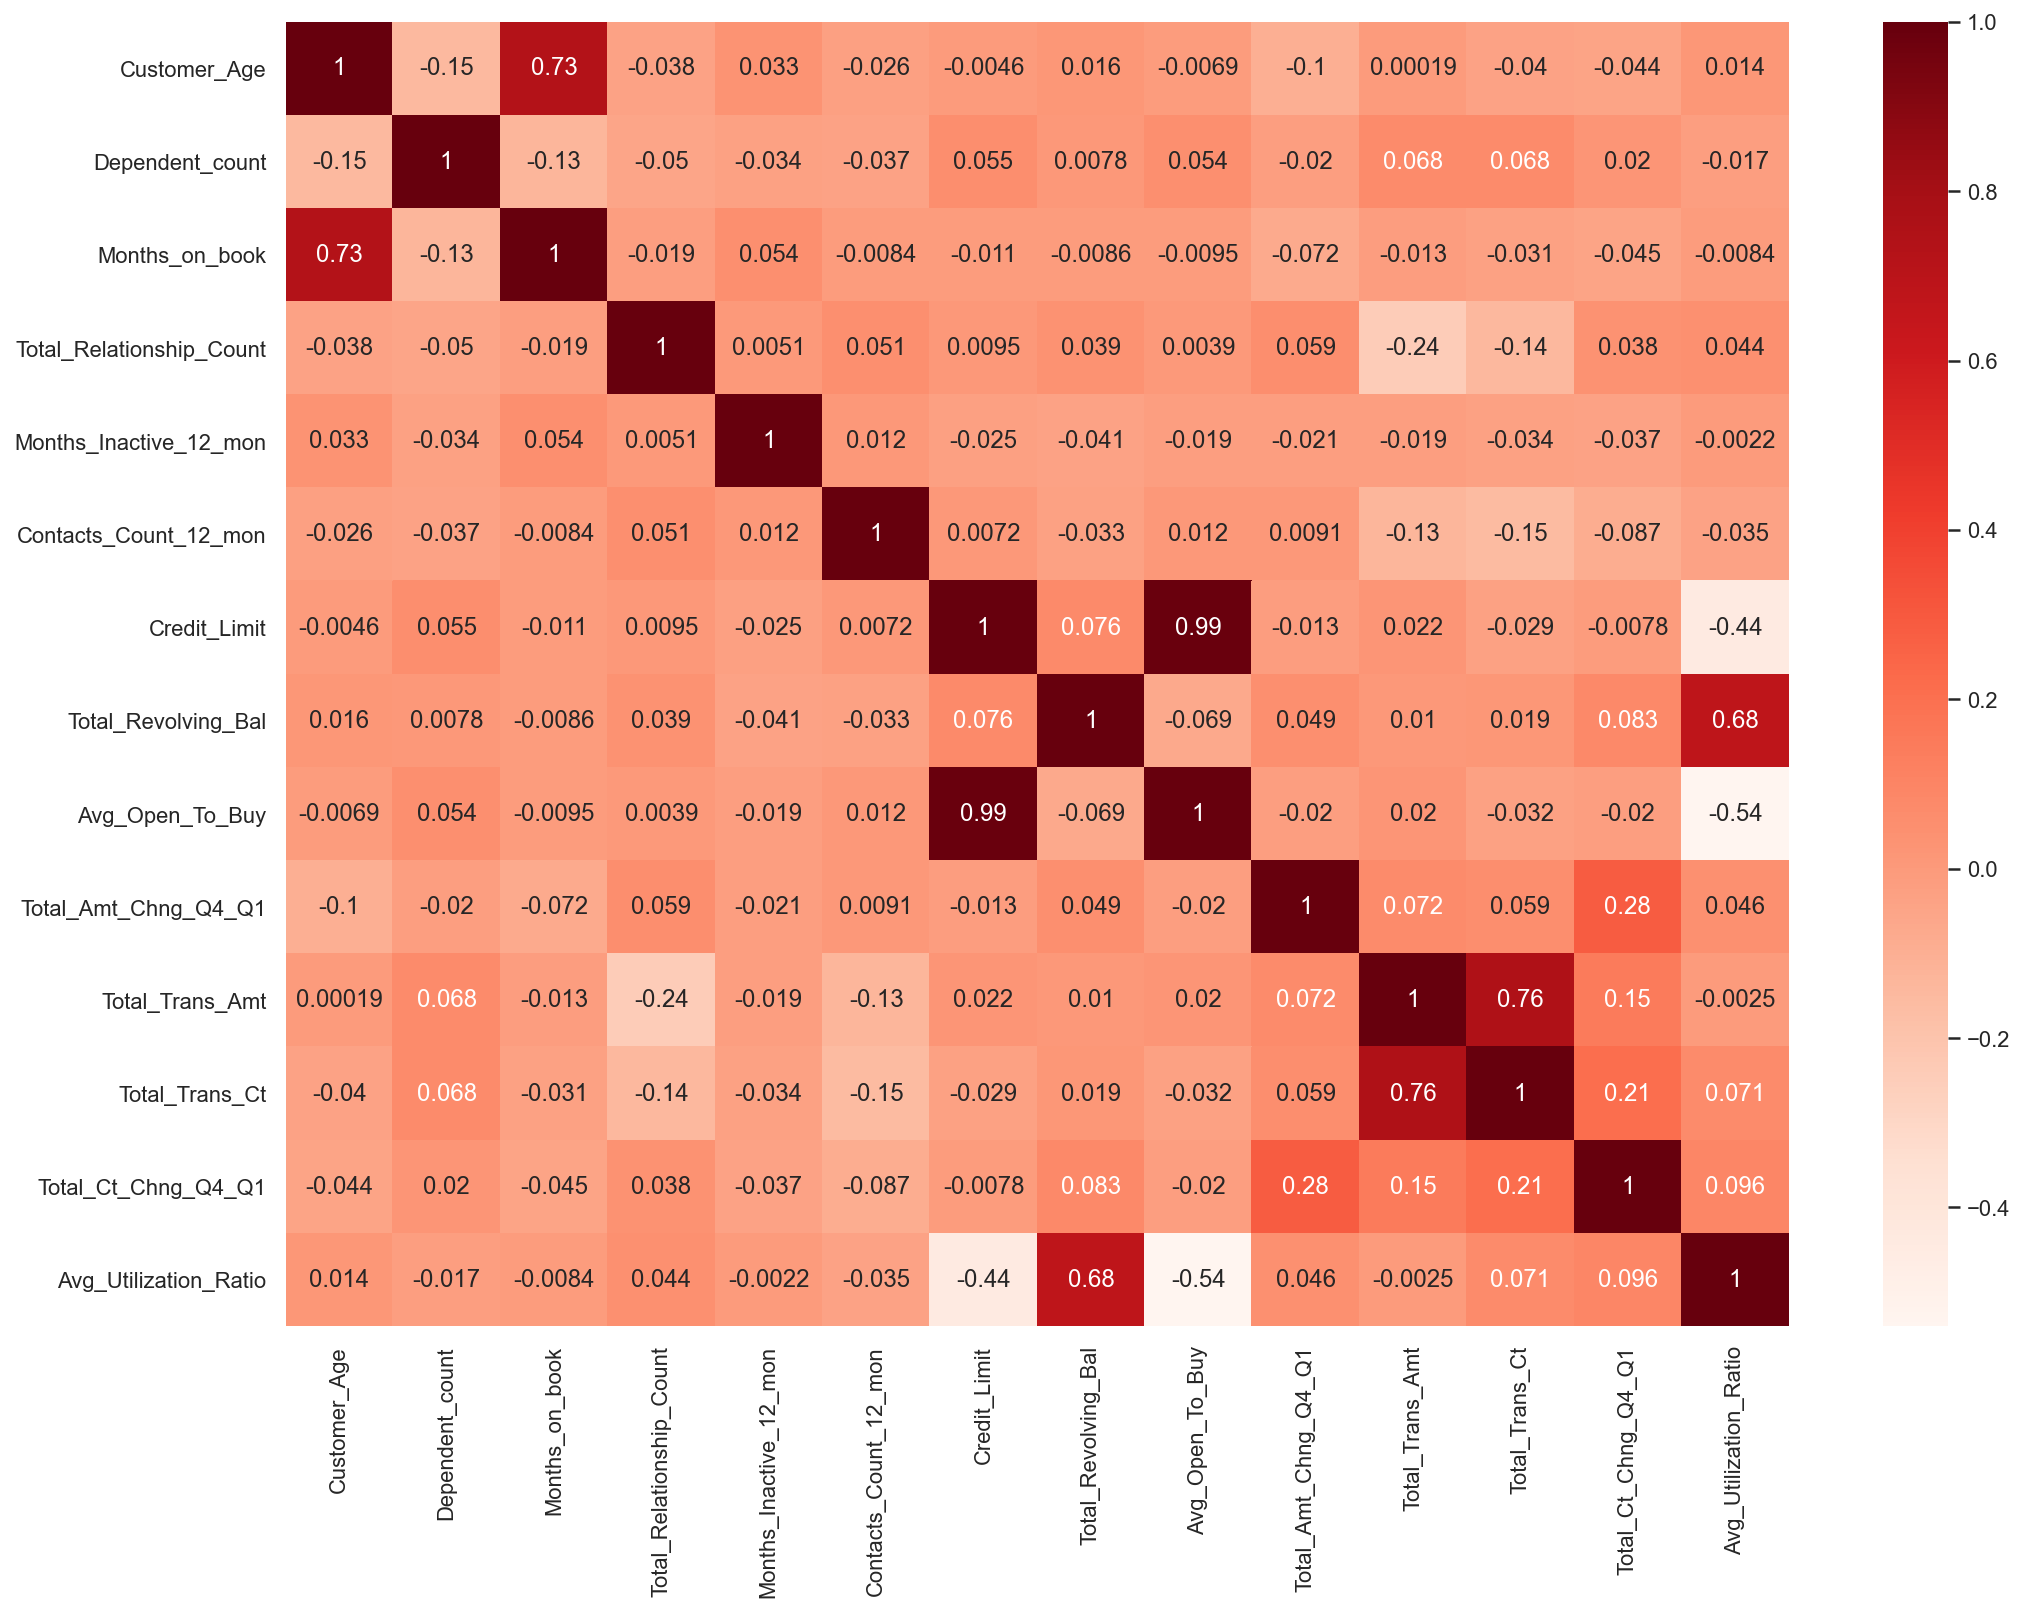

In [25]:
# Pearson correlation
plot_pearson_corrs(removed_outlier.select_dtypes(include=['number']),15,12)

In [26]:
# Drop high correlation
removed_outlier.drop(['Total_Trans_Amt','Avg_Open_To_Buy'],inplace=True, axis=1)

### The reasons that these columns are dropped
- Total_Trans_Ct: Has a high relationship with Total_Trans_Amt
- Avg_Open_To_Buy: Has a high relationship with Credit_Limit
#### Note that Due to high correlation, these columns can be used to represent each others.

## Chi-square test 

In [27]:
# Chi-square test (alpha: 0.05)
Chi_square_test(df,'Attrition_Flag').sort_values('p-value', ascending=False)

,column name,p-value
4,Card_Category,0.759710
2,Marital_Status,0.119615
1,Education_Level,0.044879
3,Income_Category,0.015177
0,Gender,0.003255


In [28]:
# Drop the columns that don't have relationship with the target values 'Attrition_Flag' (p-value > alpha)
# - Card_Category
# - Education_Level
cleaned_data = removed_outlier.drop(['Card_Category','Education_Level'],axis=1)

In [29]:
cleaned_data.head()

,Attrition_Flag,Gender,Marital_Status,Income_Category,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,M,Married,$40K - $60K,44,2,36,3,1,2,4010.0,1247,1.376,24,0.846,0.311
1,Existing Customer,M,Single,$80K - $120K,48,2,36,6,3,3,11656.0,1677,1.524,32,0.882,0.144
2,Existing Customer,F,Married,Less than $40K,57,2,48,5,2,2,2436.0,680,1.190,29,0.611,0.279
3,Existing Customer,F,Single,Less than $40K,41,3,28,6,1,2,7768.0,1669,0.797,22,0.833,0.215
4,Existing Customer,F,Married,Less than $40K,53,2,38,5,2,3,2650.0,1490,1.750,28,1.000,0.562


# Build model

## Apply One-hot encoding (dummies)

In [30]:
# Apply One-hot encoding on categorical columns
cleaned_df = pd.get_dummies(cleaned_data.drop('Attrition_Flag',axis=1))

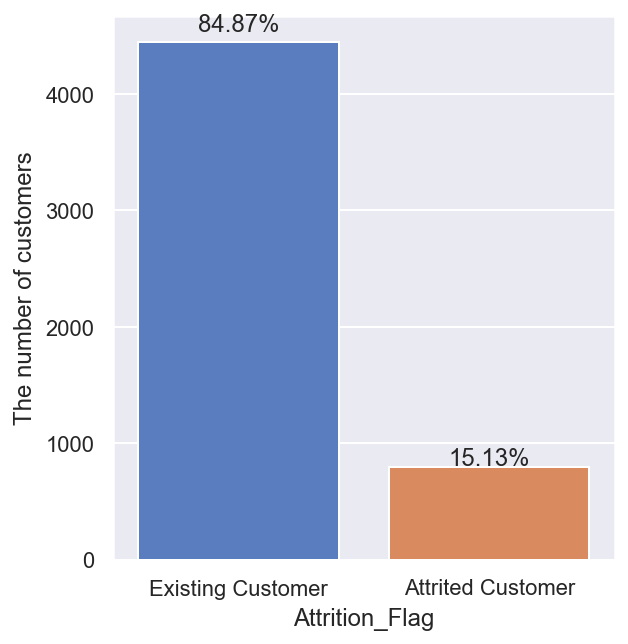

In [31]:
# Check target ratio
countplot(cleaned_data,'Attrition_Flag')

## Declare X (features) and y (label)

In [32]:
# Declare a target
# Replace the target values which Existing Customer -> 0, Attrited Customer -> 1 for ROC graph calculation
y = removed_outlier['Attrition_Flag'].replace(['Existing Customer','Attrited Customer'], [0,1])

# Declare features
X = cleaned_df.copy()
X.head()

# Split the data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Train XGBoost model

In [33]:
# Original XGBoost model 
clf = xgb.XGBClassifier(objective='binary:logistic', seed=42, eval_metric='auc')
clf.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='auc',
        eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.93190
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.93853
[2]	validation_0-auc:0.94565
[3]	validation_0-auc:0.95082
[4]	validation_0-auc:0.94991
[5]	validation_0-auc:0.95494
[6]	validation_0-auc:0.95523
[7]	validation_0-auc:0.95636
[8]	validation_0-auc:0.95993
[9]	validation_0-auc:0.96182
[10]	validation_0-auc:0.96223
[11]	validation_0-auc:0.96516
[12]	validation_0-auc:0.96489
[13]	validation_0-auc:0.96500
[14]	validation_0-auc:0.96523
[15]	validation_0-auc:0.96564
[16]	validation_0-auc:0.96468
[17]	validation_0-auc:0.96546
[18]	validation_0-auc:0.96668
[19]	validation_0-auc:0.96661
[20]	validation_0-auc:0.96715
[21]	validation_0-auc:0.96701
[22]	validation_0-auc:0.96652
[23]	validation_0-auc:0.96723
[24]	validation_0-auc:0.96737
[25]	validation_0-auc:0.96790
[26]	validation_0-auc:0.96805
[27]	validation_0-auc:0.96791
[28]	validation_0-auc:0.96817
[29]	validation_0-auc:0.96810
[30]	validation_0-auc:0.96879
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## The original XGBoost evaluation

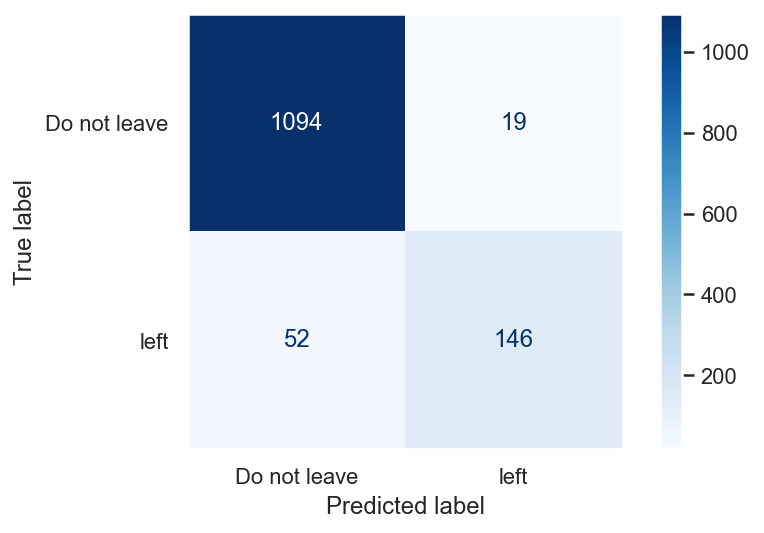

In [34]:
# Plot confusion matrix 
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not leave','left'])
# Hide background grid
plt.grid(b=None)

## Optimizing XGBoost hyperparameters

In [35]:
# GridSearch to find optimal hyperparameters
# ROUND 1
param_grid = {
    'max_depth': [4,5,6], # Tree depth
    'learning_rate': [0.1, 0.2,0.3], # The value that use to prune the tree
    'gamma': [0, 1], # Max tree depth
    'reg_lambda': [0, 0.5, 1], # L2 regularization
    'min_child_weight':[0, 1] # Cover 
}

# Optimizie xgboosthyperparameters
optimized_xgb = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose=2,
    n_jobs = -1)

optimized_xgb.fit(X_train,
                y_train,
                verbose=True, # Do not print the process
                early_stopping_rounds=10, # stop a validation if the eval_metric score doesn’t improve for n rounds
                eval_metric='auc', # an evaluation metric (Benchmark)
                eval_set=[(X_test, y_test)])
print(optimized_xgb.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   38.7s


[0]	validation_0-auc:0.91161
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92655
[2]	validation_0-auc:0.92569
[3]	validation_0-auc:0.92972
[4]	validation_0-auc:0.93608
[5]	validation_0-auc:0.93870
[6]	validation_0-auc:0.94664
[7]	validation_0-auc:0.94767
[8]	validation_0-auc:0.95064
[9]	validation_0-auc:0.95496
[10]	validation_0-auc:0.95844
[11]	validation_0-auc:0.95860
[12]	validation_0-auc:0.95971
[13]	validation_0-auc:0.95913
[14]	validation_0-auc:0.96062
[15]	validation_0-auc:0.96100
[16]	validation_0-auc:0.96237
[17]	validation_0-auc:0.96317
[18]	validation_0-auc:0.96415
[19]	validation_0-auc:0.96487
[20]	validation_0-auc:0.96555
[21]	validation_0-auc:0.96609
[22]	validation_0-auc:0.96696
[23]	validation_0-auc:0.96717
[24]	validation_0-auc:0.96712
[25]	validation_0-auc:0.96660
[26]	validation_0-auc:0.96723
[27]	validation_0-auc:0.96745
[28]	validation_0-auc:0.96738
[29]	validation_0-auc:0.96749
[30]	validation_0-auc:0.96822
[31]	validation_

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   53.9s finished


## The optimal XGBoost evaluation

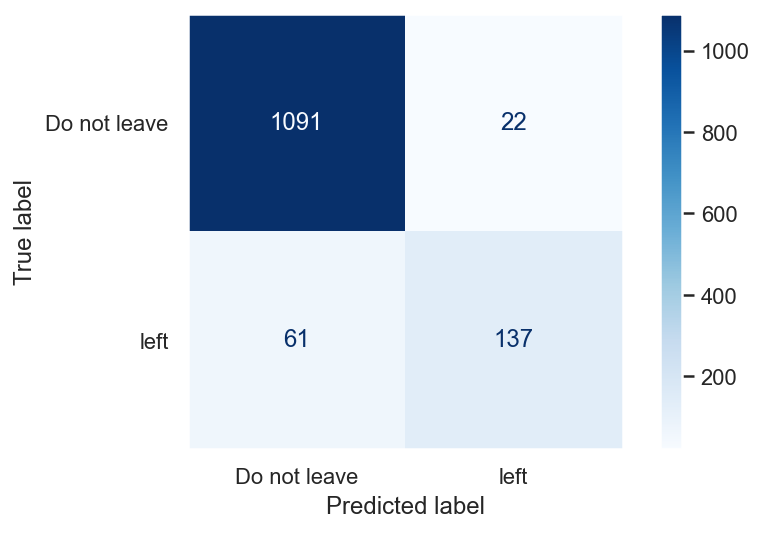

In [36]:
# Plot confusion matrix 
plot_confusion_matrix(optimized_xgb,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not leave','left'])
# Hide background grid
plt.grid(b=None)

## Roc graph between Initial and optimal model

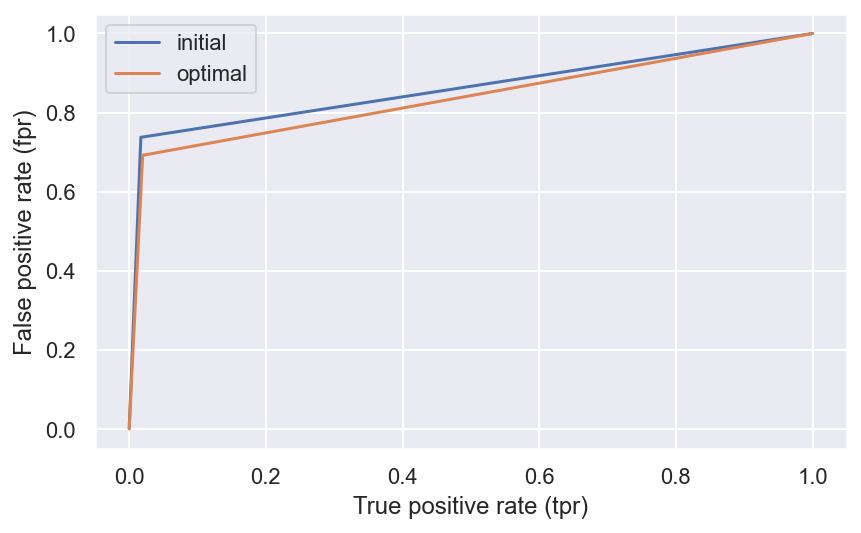

In [37]:
# Plot initial and optimal models ROC graph
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")

# Initial model
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.predict(X_test))
plt.plot(fpr, tpr)

# Optimal model
fpr, tpr, thresholds = roc_curve(y_test, optimized_xgb.predict(X_test))
roc_auc_score(y_test, optimized_xgb.predict(X_test))
plt.plot(fpr, tpr)

plt.gca().legend(('initial','optimal'))

In [38]:
print ("Initial model AUC score:",round(roc_auc_score(y_test, clf.predict(X_test)),2)*100)
print ("Optimal model AUC score:",round(roc_auc_score(y_test, optimized_xgb.predict(X_test)),2)*100)

Initial model AUC score: 86.0
Optimal model AUC score: 84.0


## The difference between the AUC value in the training and the validation data set
Make sure that the testing AUC value are not higher that testing value to prevent an overfitting problem.

## Training dataset

In [39]:
# Testing dataset
training_pred = optimized_xgb.predict(X_train)

# ROC
training_fpr, training_tpr, training_thresholds = roc_curve(y_train, training_pred)

# AUC
roc_auc_score(y_train, training_pred)

0.888513139068577

## Testing dataset

In [40]:
# Training dataset
testing_pred = optimized_xgb.predict(X_test)

# ROC
testing_fpr, testing_tpr, testing_thresholds = roc_curve(y_test, testing_pred)

# AUC
roc_auc_score(y_test, testing_pred)

0.8360763973971521

## Comparison of ROC for training and testing dataset

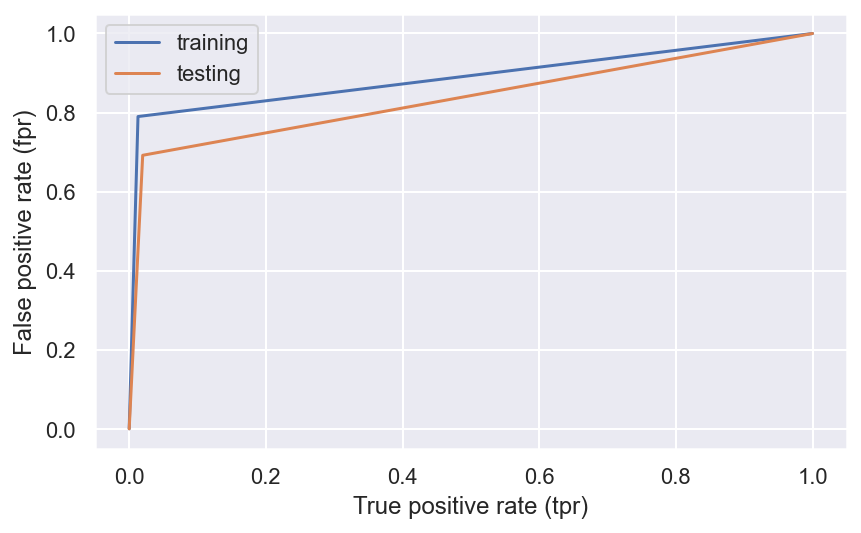

In [41]:
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")

plt.plot(training_fpr, training_tpr)
plt.plot(testing_fpr, testing_tpr)

plt.gca().legend(('training','testing'))

## Comparison of classifiers

### Build candidates models

In [42]:
# Find Accuarcy for each classifier model
# Logistic Classifier
logistic_clf = LogisticRegression(n_jobs=-1, random_state=42).fit(X_train, y_train)
logistic_acc = (logistic_clf.predict(X_test) == y_test).mean()*100

# NaiveBayes Classifier
gnb = GaussianNB().fit(X_train, y_train)
gnb_acc = (gnb.predict(X_test) == y_test).mean()*100

# KNN Classifier
KNN_neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
KNN_acc = (KNN_neigh.predict(X_test) == y_test).mean()*100

# Support Vector Machine
# Longtime to train
svc = SVC(gamma='auto').fit(X_train, y_train)
svc_acc = (svc.predict(X_test) == y_test).mean()*100

# Decision Tree Classifier
decision_tree_clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
decision_tree_acc = (logistic_clf.predict(X_test) == y_test).mean()*100

In [43]:
# Define randomforest hyperparameters
# Create the grid parameters
param_grid = {'n_estimators': [150, 200], # Number of trees in random forest
                  'max_depth': [11, 13], # Maximum number of levels in tree
                  'min_samples_split': [7,9,11], # Minimum number of samples required to split a node
                  'min_samples_leaf': [1,2], # Minimum number of samples required at each leaf node
                  'bootstrap': [True, False], # True: Bootstrap samples are used when building trees False: The whole dataset is used to build each tree
                  'random_state': [42]} # Method of selecting samples for training each tree
    
 # Perform the gridsearch and cross-validation to search for best hyperparameters
optimized_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid=param_grid, cv = 5, verbose=2, n_jobs = -1)

# Fit data to the opimize rf model
optimized_rf.fit(X_train, y_train)

# Random Forest Classifier Accuarcy
rf_acc = (optimized_rf.predict(X_test) == y_test).mean()*100

print(optimized_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   29.3s finished


{'bootstrap': False, 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200, 'random_state': 42}


In [44]:
xgb_acc = (optimized_xgb.predict(X_test) == y_test).mean()*100

## ROC graphs

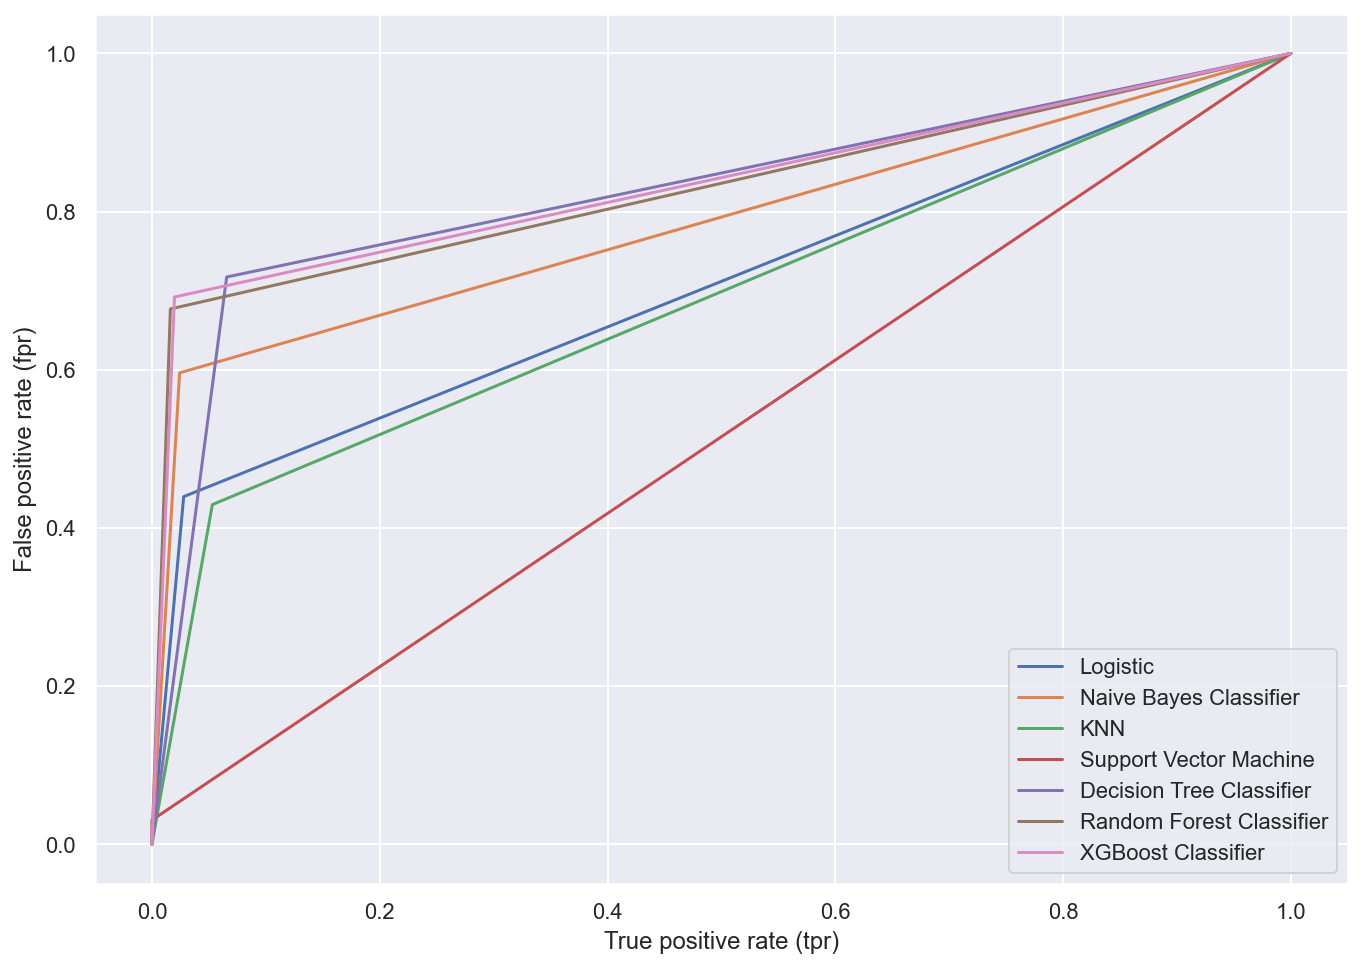

In [45]:
# Plot an ROC graph for each model
plt.figure(figsize=(10, 8))

plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")
 
# Logistic
fpr, tpr, thresholds = roc_curve(y_test, logistic_clf.predict(X_test))
logistic_auc = roc_auc_score(y_test, logistic_clf.predict(X_test))
plt.plot(fpr, tpr)
# Naive Bayes Classifier
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict(X_test))
gnb_auc = roc_auc_score(y_test, gnb.predict(X_test))
plt.plot(fpr, tpr)
# KNN
fpr, tpr, thresholds = roc_curve(y_test, KNN_neigh.predict(X_test))
KNN_auc = roc_auc_score(y_test, KNN_neigh.predict(X_test))
plt.plot(fpr, tpr)
# Support Vector Machine
fpr, tpr, thresholds = roc_curve(y_test, svc.predict(X_test))
svc_auc = roc_auc_score(y_test, svc.predict(X_test))
plt.plot(fpr, tpr)
# Decision Tree Classifier
fpr, tpr, thresholds = roc_curve(y_test, decision_tree_clf.predict(X_test))
decision_tree_auc = roc_auc_score(y_test, decision_tree_clf.predict(X_test))
plt.plot(fpr, tpr)
# Random Forest Classifier
fpr, tpr, thresholds = roc_curve(y_test, optimized_rf.predict(X_test))
rf_auc = roc_auc_score(y_test, optimized_rf.predict(X_test))
plt.plot(fpr, tpr)
# XGBoost Classifier
fpr, tpr, thresholds = roc_curve(y_test, optimized_xgb.predict(X_test))
xgb_auc = roc_auc_score(y_test, optimized_xgb.predict(X_test))
plt.plot(fpr, tpr)

plt.gca().legend(('Logistic','Naive Bayes Classifier','KNN','Support Vector Machine',
                  'Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'))

## Comparison table

### AUC score

In [46]:
# Comparison of models
# Create AUC score for each candidate model
AUC_models = pd.DataFrame({
    'Model':['Logistic','Naive Bayes Classifier','KNN','Support Vector Machine','Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'],
    'AUC score':[logistic_auc,gnb_auc,KNN_auc,svc_auc,decision_tree_auc,rf_auc,xgb_auc]
})
AUC_models['AUC score'] = AUC_models['AUC score'].round(2)
AUC_models.sort_values(by='AUC score', ascending=False)

,Model,AUC score
6,XGBoost Classifier,0.84
4,Decision Tree Classifier,0.83
5,Random Forest Classifier,0.83
1,Naive Bayes Classifier,0.79
0,Logistic,0.71
2,KNN,0.69
3,Support Vector Machine,0.52


### Model Accuracy

In [47]:
# Comparison of models
# Create Accuracy for each candidate model
comp_models = pd.DataFrame({
    'Model':['Logistic','Naive Bayes Classifier','KNN','Support Vector Machine','Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'],
    'Accuracy':[logistic_acc,gnb_acc,KNN_acc,svc_acc,decision_tree_acc,rf_acc,xgb_acc]
})
comp_models['Accuracy'] = comp_models['Accuracy'].round(2)
comp_models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
5,Random Forest Classifier,93.75
6,XGBoost Classifier,93.67
1,Naive Bayes Classifier,91.84
0,Logistic,89.17
4,Decision Tree Classifier,89.17
2,KNN,86.88
3,Support Vector Machine,85.35


## Comparison between optimal XGBoost and Optimal Random Forest models

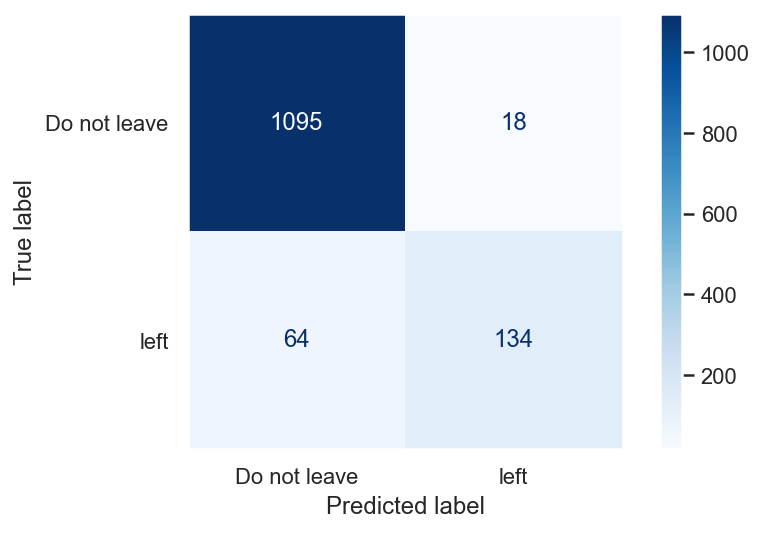

In [48]:
# Plot XGBoost confusion matrix 
plot_confusion_matrix(optimized_rf,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not leave','left'])
# Hide background grid
plt.grid(b=None)

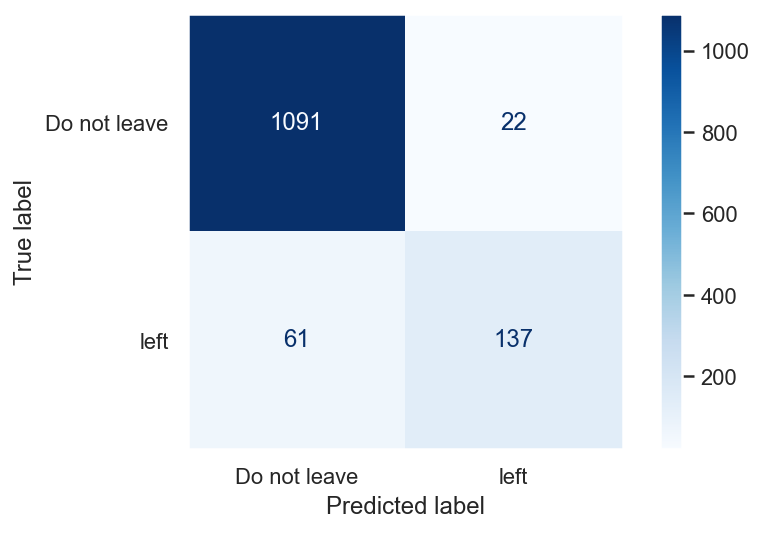

In [49]:
# Plot Random Forest confusion matrix 
plot_confusion_matrix(optimized_xgb,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not leave','left'])
# Hide background grid
plt.grid(b=None)

# Top feature that affects customer leaving

In [50]:
# Get XGBoost feature importances
feat_importances = optimized_xgb.best_estimator_.get_booster().get_score(importance_type="gain")
sorted_feat_importances = dict(sorted(feat_importances.items(), key=lambda item: item[1], reverse=True))
sorted_feat_importances

{'Total_Trans_Ct': 25.817870669125,
 'Total_Revolving_Bal': 24.3761922362295,
 'Total_Relationship_Count': 16.715953608787874,
 'Months_Inactive_12_mon': 10.765961967419354,
 'Gender_F': 9.648529084999998,
 'Total_Ct_Chng_Q4_Q1': 8.57408923983871,
 'Avg_Utilization_Ratio': 7.98886340736842,
 'Marital_Status_Married': 7.01519002,
 'Credit_Limit': 6.15003754020408,
 'Income_Category_$60K - $80K': 5.76704717,
 'Contacts_Count_12_mon': 5.302283854800001,
 'Total_Amt_Chng_Q4_Q1': 5.098380281107692,
 'Customer_Age': 5.092604735357144,
 'Months_on_book': 4.422426160526316,
 'Marital_Status_Divorced': 3.40880919,
 'Dependent_count': 3.3013409974999997,
 'Income_Category_$40K - $60K': 2.21688533,
 'Marital_Status_Single': 1.36421287}

In [62]:
# Select top features
top_feats = [key for key in sorted_feat_importances]
top_feats[:10]

['Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Gender_F',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Marital_Status_Married',
 'Credit_Limit',
 'Income_Category_$60K - $80K']

## Top features data visualization

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 59.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


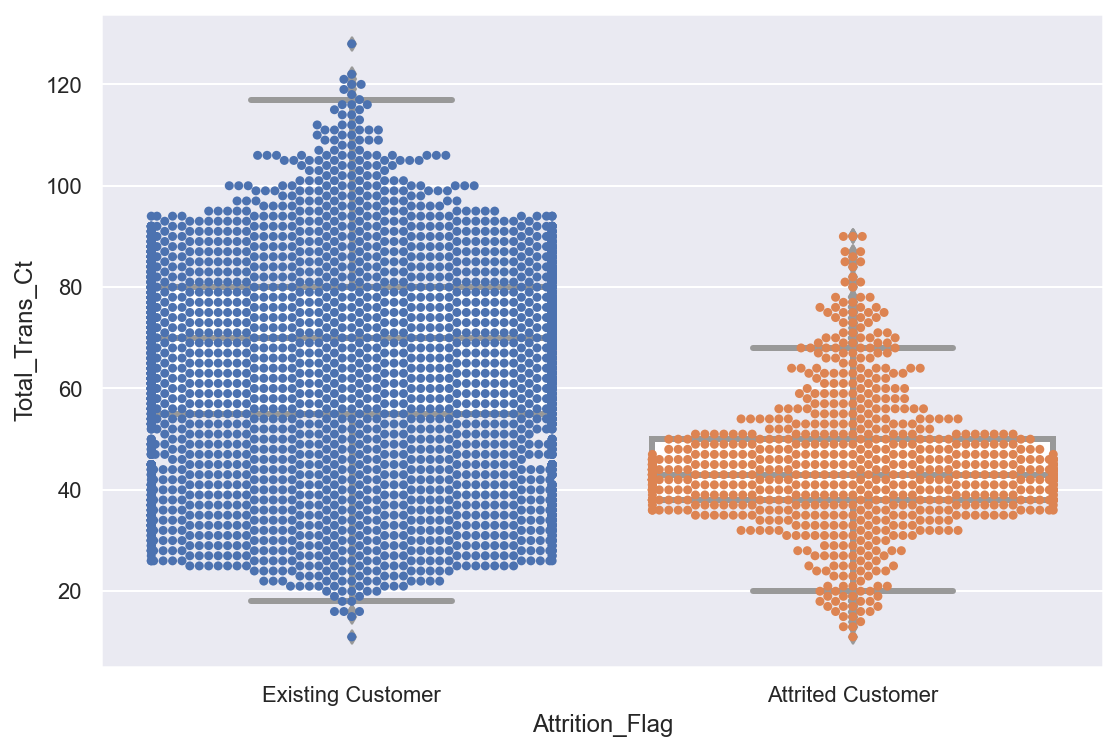

In [52]:
# Total_Trans_Ct
plot_swarmbox(removed_outlier,'Attrition_Flag','Total_Trans_Ct')

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


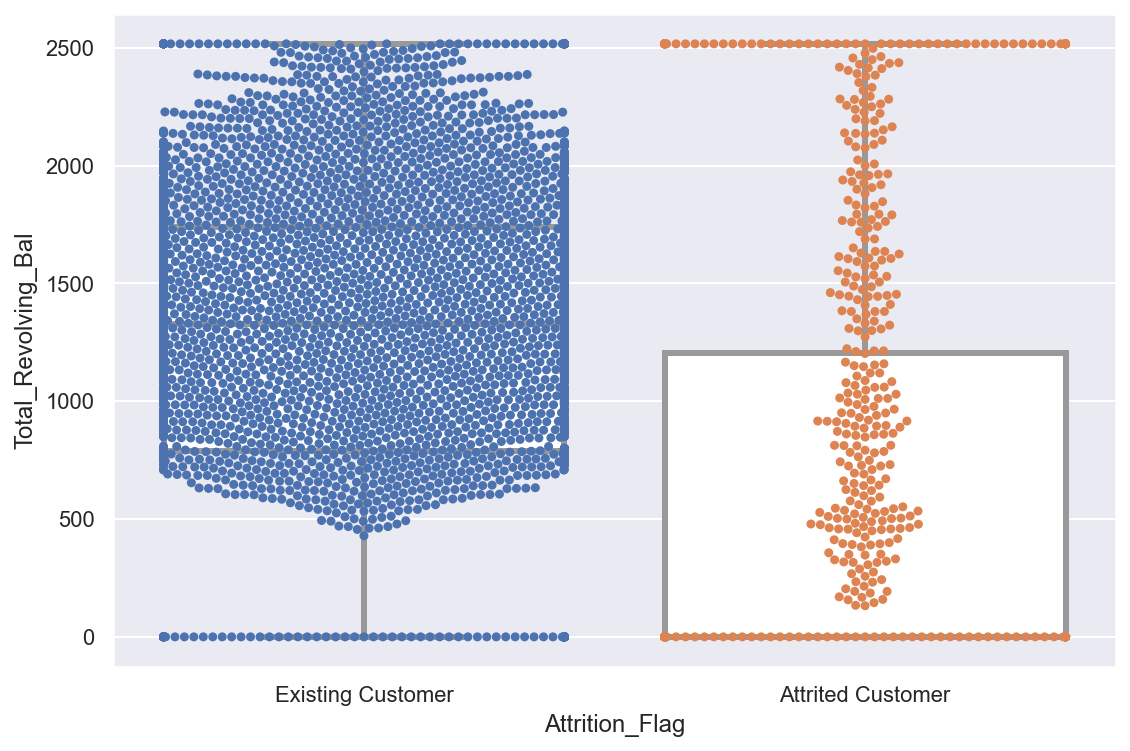

In [53]:
# Total_Revolving_Bal
plot_swarmbox(removed_outlier,'Attrition_Flag','Total_Revolving_Bal')

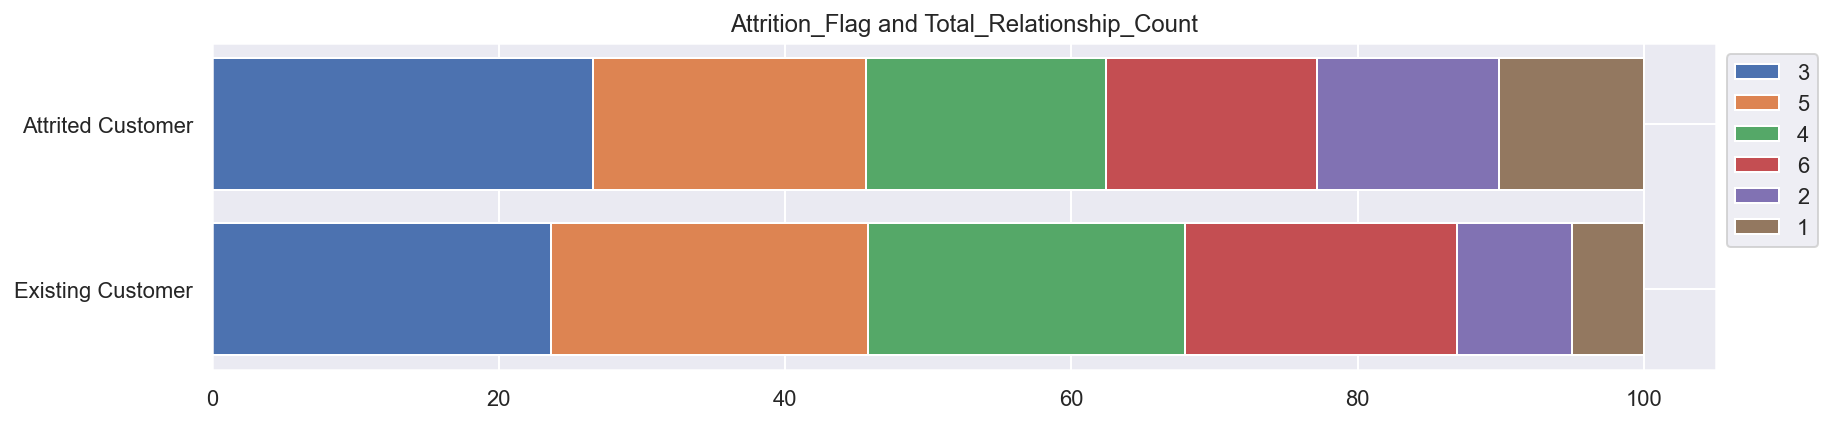

In [54]:
# Total_Relationship_Count
stacked_plot(removed_outlier,'Attrition_Flag','Total_Relationship_Count')

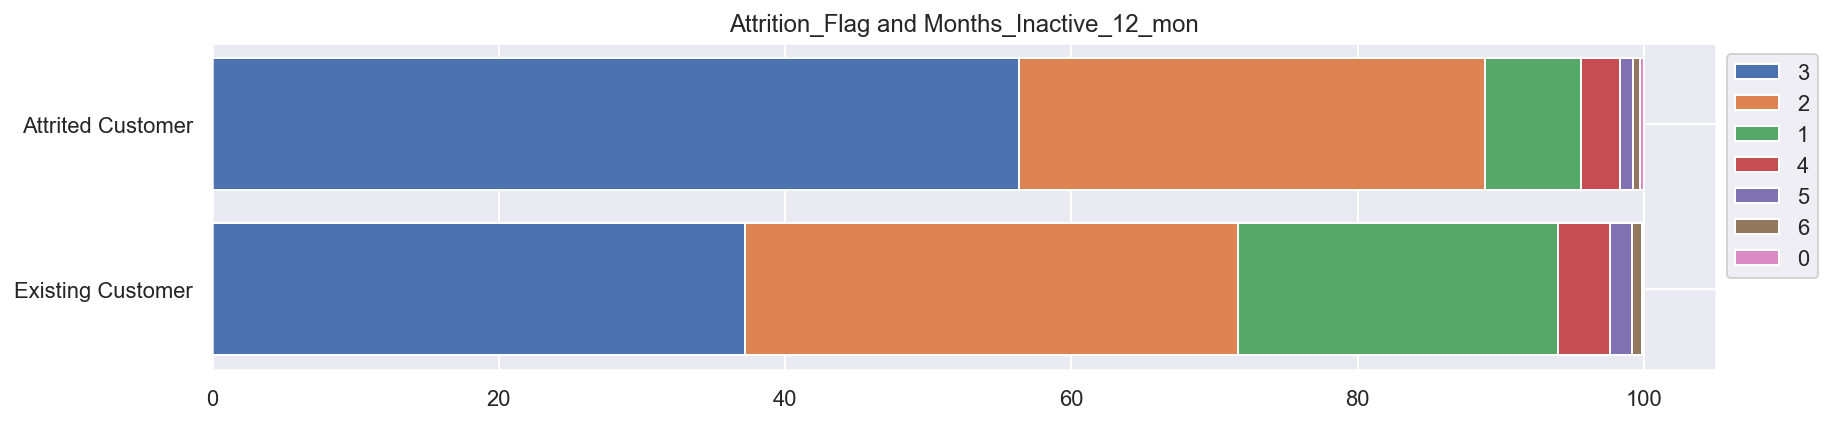

In [55]:
# Months_Inactive_12_mon
stacked_plot(removed_outlier,'Attrition_Flag','Months_Inactive_12_mon')

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


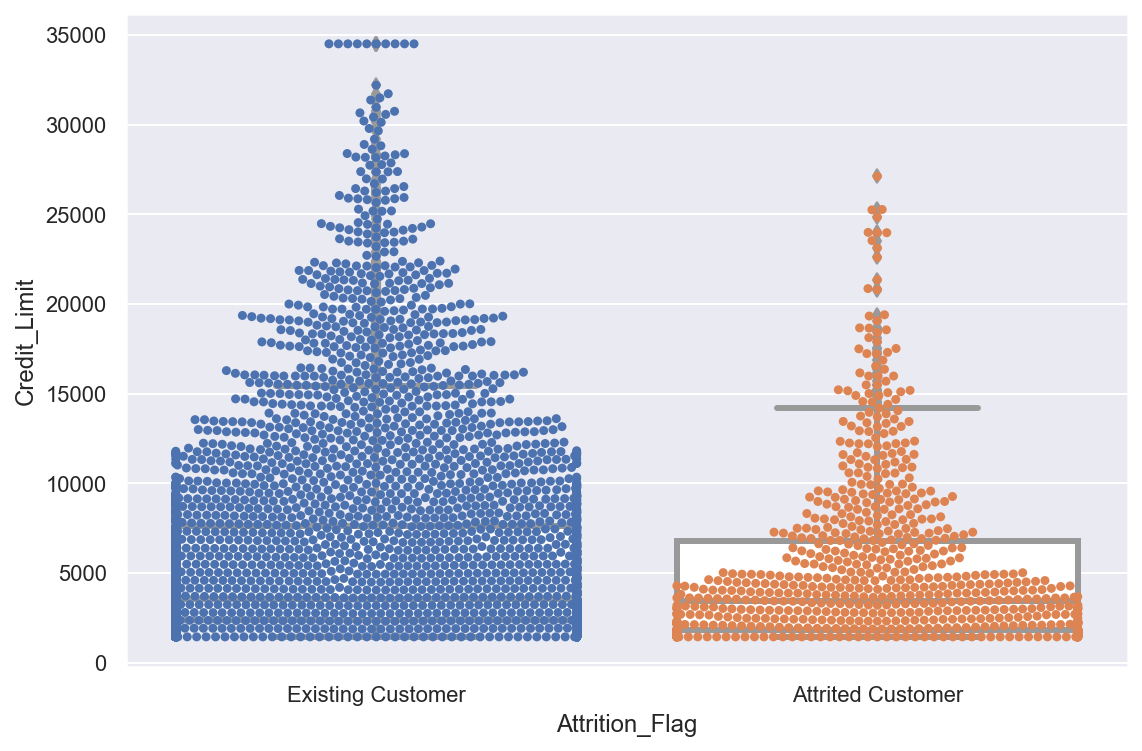

In [60]:
# Credit_Limit
plot_swarmbox(removed_outlier,'Attrition_Flag','Credit_Limit')

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


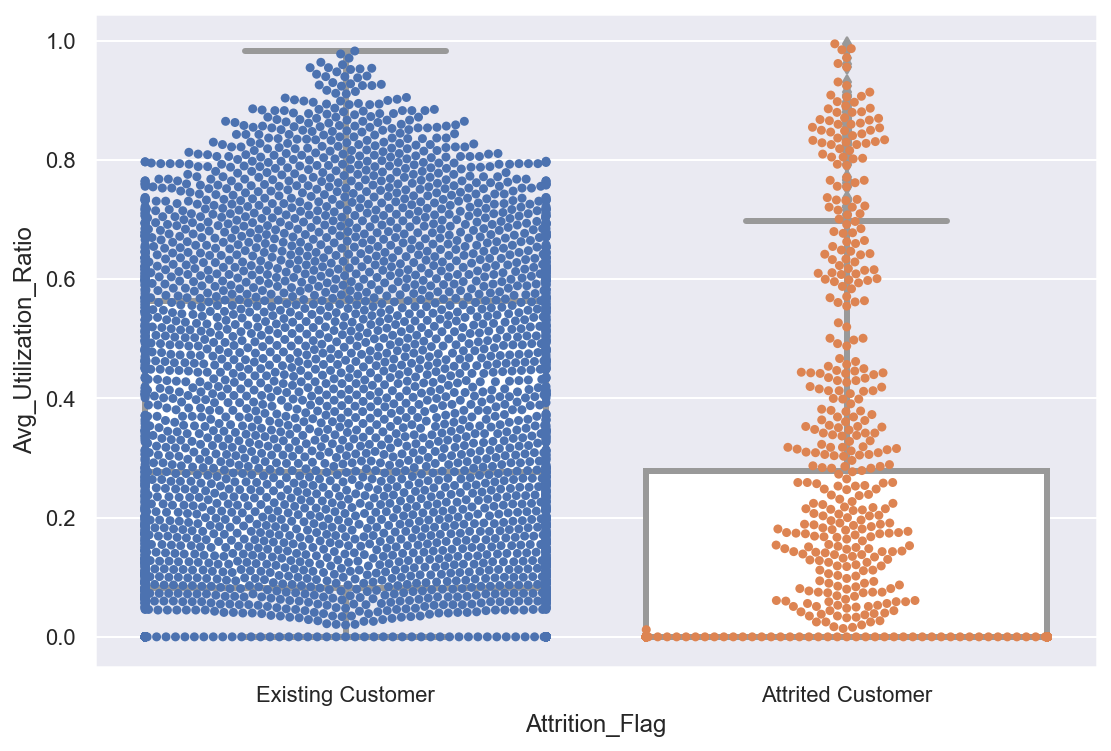

In [56]:
# Avg_Utilization_Ratio
plot_swarmbox(removed_outlier,'Attrition_Flag','Avg_Utilization_Ratio')

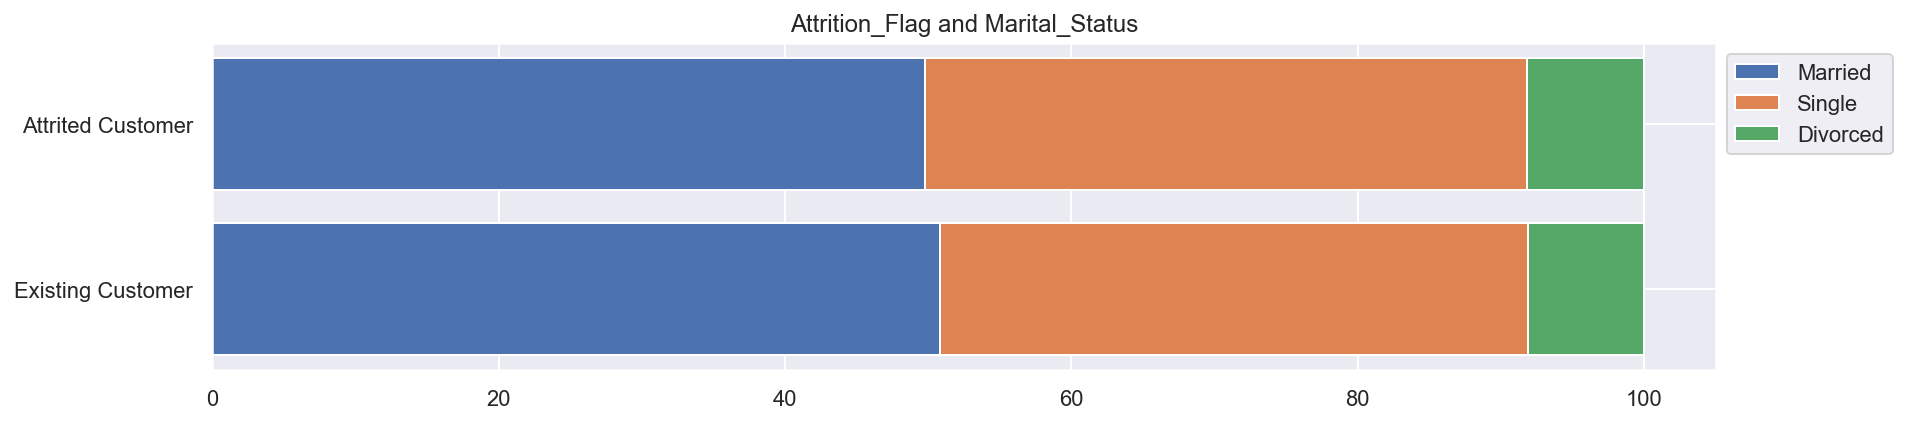

In [61]:
# Marital_Status
stacked_plot(removed_outlier,'Attrition_Flag','Marital_Status')

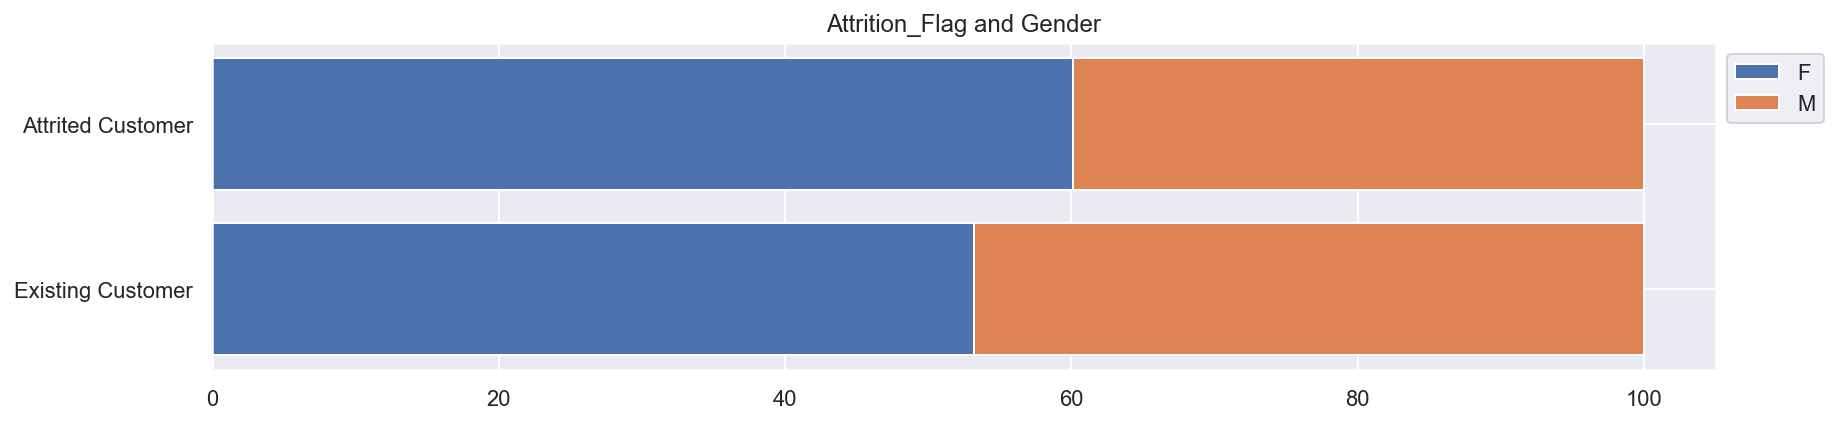

In [57]:
# Gender
stacked_plot(removed_outlier,'Attrition_Flag','Gender')

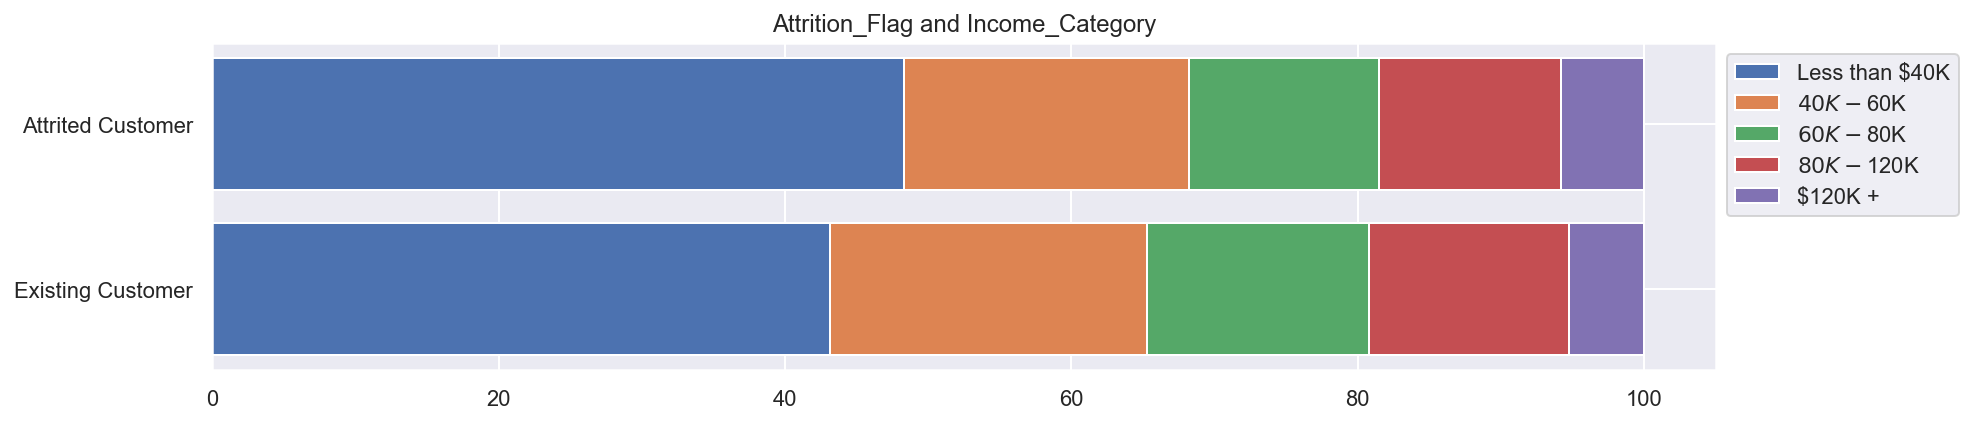

In [58]:
# Income_Category
stacked_plot(removed_outlier,'Attrition_Flag','Income_Category')